In [41]:
# !pip install pandas
import pandas as pd
import os
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
    
import ast
import re
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

In [42]:
def process_string(input_string):
    reduced_spaces = re.sub(r'\s+', ' ', input_string)
    trimmed = re.sub(r'^[^\w.-]+', '', reduced_spaces)
    trimmed = re.sub(r'[^\w.-]+$', '', trimmed)
    result = re.sub(r' ', ',', trimmed)
    
    return result

def extract_pose_string(text):
    return ast.literal_eval(f"[{process_string(text)}]")


def draw_direction_annotation(position, yaw, ax, scale=0.4, is_grad=True, is_goal=False):
    x, y = position
    # Convert yaw from degrees to radians
    if not is_grad:
        yaw_rad = np.deg2rad(yaw)
    else:
        yaw_rad = yaw

    
    # Calculate the direction vector based on the yaw angle
    dx = np.cos(yaw_rad)
    dy = np.sin(yaw_rad)
    
    # Calculate the perpendicular direction vector
    perp_dx = -dy
    perp_dy = dx
    
    # Scale the perpendicular vector for the short line
    line_length = 0.2
    perp_dx *= line_length
    perp_dy *= line_length
    
    # Create the plot
    ax.plot(x, y, 'ro')  # Plot the position as a red dot
    
    # Add the annotation arrow
    ax.annotate('', xy=(x + dx*scale, y + dy*scale), xytext=(x, y),
                 arrowprops=dict(facecolor='green' if is_goal else 'blue', 
                                 shrink=0.05, 
                                 width=0.5, 
                                 headwidth=5))
    
    # Draw the short perpendicular line
    ax.plot([x - perp_dx, x + perp_dx], [y - perp_dy, y + perp_dy], 'g-')

In [43]:
file_dir = "./simdata/one_pose_R1/MPC/"

def get_df_from_lines(data, parameters):
    headers = data[0].split(",")
    data_dict = {}
    for line in data[1:]:
        line_info = line.split(",")
        for idx, header in enumerate(headers):
            if header not in data_dict:
                data_dict[header] = [float(line_info[idx])]
            else:
                data_dict[header].append(float(line_info[idx]))

    df = pd.DataFrame(data_dict)
    parameters_dict = {line.split(",")[0]: "".join(line.split(",")[1:]) for line in parameters}
    df["parameters"] = str(parameters_dict)
    df["pred_step_size_multiplier"] = float(parameters_dict["pred_step_size_multiplier"])
    df["dt"] = parameters_dict["dt"]
    df["Nactor"] = float(parameters_dict["Nactor"])
    df["state_init"] = parameters_dict["state_init"]
    df["R1_diag"] = ast.literal_eval(parameters_dict["R1_diag"])
    return df


df_list = []
for root, dirs, files in os.walk(file_dir):
    for fn in files:
        if not fn.endswith(".csv"):
            continue
        file_path = os.path.join(root, fn)

        with open(file_path) as f:
            data = f.read().splitlines()

        parameters = []
        for from_line, line in enumerate(data):
            if line.startswith("t [s]"):
                break

            parameters.append(line)
        df = get_df_from_lines(data[from_line:], parameters)
        df_list.append(df)

concat_df = pd.concat(df_list)

In [44]:
# df_group_info = concat_df.groupby(['N_kappa', 'state_init']).size()
# df_group_info
# concat_df["Stanley_traj"].unique()

concat_df

,t [s],x [m],y [m],alpha [rad],run_obj,accum_obj,v [m/s],omega [rad/s],parameters,pred_step_size_multiplier,dt,Nactor,state_init,R1_diag
0,0.000100,-3.000000,-3.000000,0.001000,540.000001,54.000000,-0.220000,-0.284000,"{'System': '3wrobotNI', 'Controller': 'MPC', '...",2.0,0.1,6.0,[-3.e+00 -3.e+00 1.e-03],[10.0 50.0 1.0 0.0 0.0]
1,0.001100,-3.000200,-3.000000,0.000742,540.012050,108.001205,-0.220000,-0.284000,"{'System': '3wrobotNI', 'Controller': 'MPC', '...",2.0,0.1,6.0,[-3.e+00 -3.e+00 1.e-03],[10.0 50.0 1.0 0.0 0.0]
2,0.006043,-3.001287,-3.000000,-0.000662,540.077322,162.008937,-0.220000,-0.284000,"{'System': '3wrobotNI', 'Controller': 'MPC', '...",2.0,0.1,6.0,[-3.e+00 -3.e+00 1.e-03],[10.0 50.0 1.0 0.0 0.0]
3,0.055469,-3.012161,-2.999917,-0.014699,540.706352,216.079573,-0.220000,-0.284000,"{'System': '3wrobotNI', 'Controller': 'MPC', '...",2.0,0.1,6.0,[-3.e+00 -3.e+00 1.e-03],[10.0 50.0 1.0 0.0 0.0]
4,0.105469,-3.023158,-2.999677,-0.028899,541.298768,270.209449,2.200000,-2.840000,"{'System': '3wrobotNI', 'Controller': 'MPC', '...",2.0,0.1,6.0,[-3.e+00 -3.e+00 1.e-03],[10.0 50.0 1.0 0.0 0.0]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,6.805469,-0.000084,-0.118727,0.017774,0.141277,1544.916849,0.003265,-0.001797,"{'System': '3wrobotNI', 'Controller': 'MPC', '...",2.0,0.1,6.0,[-3.e+00 -3.e+00 1.e-03],[100.0 10.0 1.0 0.0 0.0]
139,6.855469,0.000079,-0.118724,0.017684,0.141267,1544.930976,0.004038,-0.002025,"{'System': '3wrobotNI', 'Controller': 'MPC', '...",2.0,0.1,6.0,[-3.e+00 -3.e+00 1.e-03],[100.0 10.0 1.0 0.0 0.0]
140,6.905469,0.000277,-0.118720,0.017584,0.141262,1544.945102,0.004038,-0.002025,"{'System': '3wrobotNI', 'Controller': 'MPC', '...",2.0,0.1,6.0,[-3.e+00 -3.e+00 1.e-03],[100.0 10.0 1.0 0.0 0.0]
141,6.955469,0.000479,-0.118717,0.017483,0.141266,1544.959228,0.004038,-0.002025,"{'System': '3wrobotNI', 'Controller': 'MPC', '...",2.0,0.1,6.0,[-3.e+00 -3.e+00 1.e-03],[100.0 10.0 1.0 0.0 0.0]


In [46]:
# chosen_dt = concat_df["dt"].unique()[1]
# sub_df_1 = concat_df[concat_df["dt"] == chosen_dt]
# sub_df_1

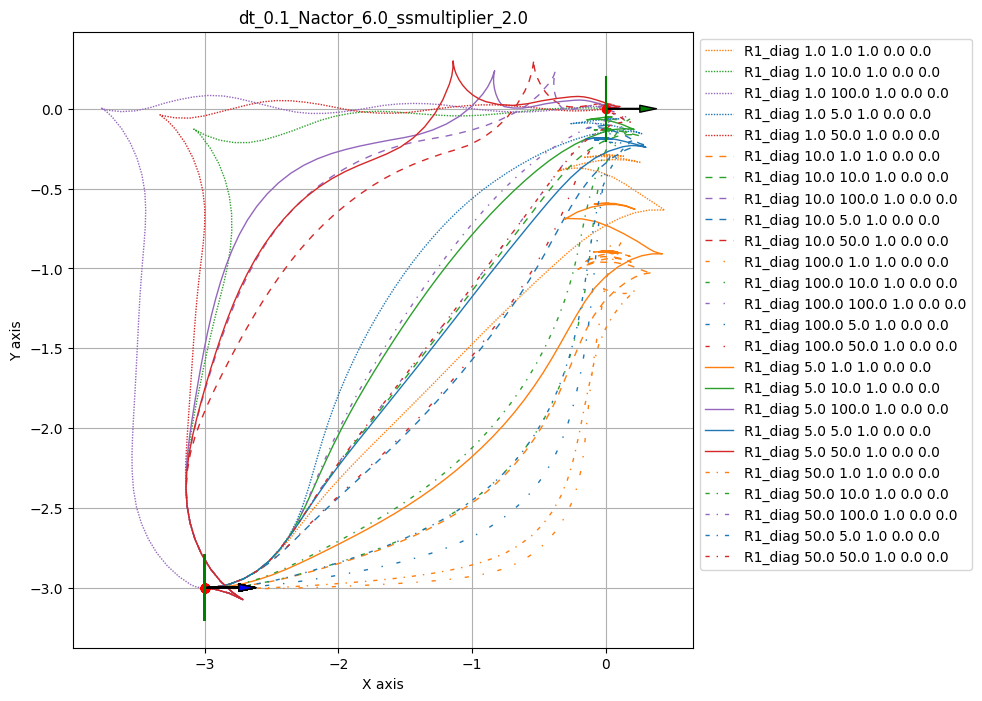

In [50]:
linestyle_dict = {
     'loosely dotted': (0, (1, 10)),
     'dotted': (0, (1, 1)),
     'densely dotted': (0, (1, 1)),
     'long dash with offset': (5, (10, 3)),
     'loosely dashed': (0, (5, 10)),
     'dashed': (0, (5, 5)),
     'densely dashed': (0, (5, 1)),
     'loosely dashdotted': (0, (3, 10, 1, 10)),
     'dashdotted': (0, (3, 5, 1, 5)),
     'densely dashdotted': (0, (3, 1, 1, 1)),
     'dashdotdotted': (0, (3, 5, 1, 5, 1, 5)),
     'loosely dashdotdotted': (0, (3, 10, 1, 10, 1, 10)),
     'densely dashdotdotted': (0, (3, 1, 1, 1, 1, 1)),
     'solid': 'solid'
}
style = {
            1: "dotted", 
            5: "solid", 
            10: "dashed", 
            50: "dashdotted", 
            100: "loosely dashdotted"
        }

colors = {
            1: "tab:orange", 
            5: "tab:blue", 
            10: "tab:green", 
            50: "tab:red", 
            100: "tab:purple"
        }

def plot_trajectories_given_trajectory(image_path):
    sub_df_1 = concat_df
    trials = list(sub_df_1["parameters"].unique())
    trials.sort()

    fig, ax = plt.subplots(sharey=True, figsize=(8, 8))
    for param_trial in trials:
        sub_df_2 = sub_df_1[sub_df_1["parameters"] == param_trial]
        R1_diag = extract_pose_string(sub_df_2["R1_diag"].iloc[0])
        ax.plot(sub_df_2["x [m]"], sub_df_2["y [m]"], 
                linestyle=linestyle_dict[style[int(R1_diag[0])]],
                lw=1, color=colors[int(R1_diag[1])],
                label="R1_diag {} {} {} {} {}".format(*R1_diag))

        # draw initial pose
        pose_arr = extract_pose_string(sub_df_2["state_init"].iloc[0])
        draw_direction_annotation(pose_arr[:2], pose_arr[2], ax)

    ax.set_title("dt_{}_Nactor_{}_ssmultiplier_{}".format(sub_df_2["dt"].iloc[2], 
                                                          sub_df_2["Nactor"].iloc[2], 
                                                          sub_df_2["pred_step_size_multiplier"].iloc[2]))
    draw_direction_annotation([0, 0], 0, ax, is_goal=True)
    # draw goal pose
    ax.legend(bbox_to_anchor=(1, 1))

    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    
    # Show the plot
    ax.grid(True)
    # Set plot limits for better visualization
    # ax.set_xlim(-2, 6)
    # ax.set_ylim(-4, 2)

    fig.savefig(image_path, dpi=fig.dpi)

plot_trajectories_given_trajectory(os.path.join("media", "MPC_dt_01_Nactor_6_multiplier_2.svg"))
# linestyle_dict[style[10]]

In [8]:
concat_df["dt"].unique()

array(['0.1', '0.3', '0.2'], dtype=object)

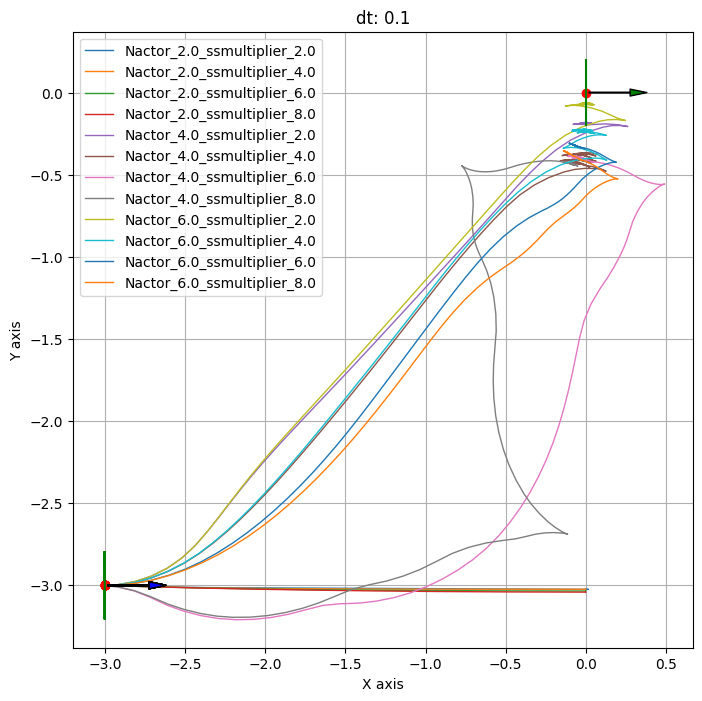

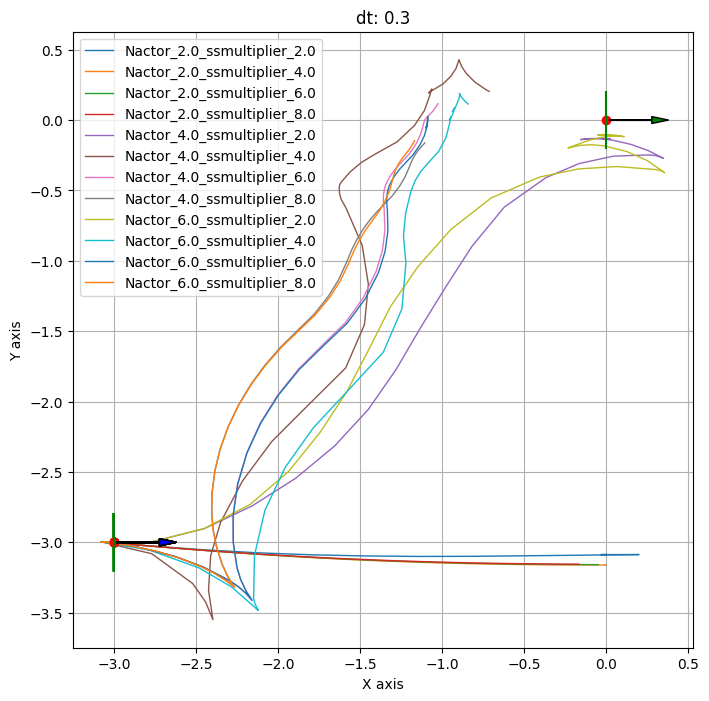

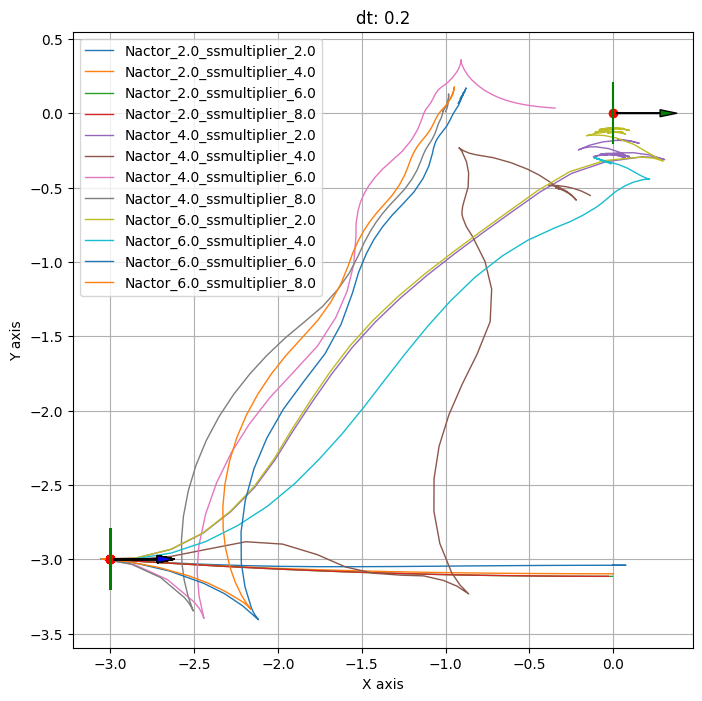

In [14]:
for dt in concat_df["dt"].unique():
    fn = "MPC_onepose_dt_{}.svg".format(dt)
    file_path = os.path.join("media", fn)
    plot_trajectories_given_trajectory(dt, file_path)

In [59]:
sub_df_1 = concat_df[concat_df["N_kappa"] == chosen_kappa]
pose_list = sub_df_1["state_init"].unique()

inital_angle = np.array([extract_pose_string(p) for p in pose_list])
inital_angles = list(set(inital_angle[:, 2]))

for i_ax, inital_angle in enumerate(inital_angles):
    for pose in pose_list:
        pose_arr = extract_pose_string(pose)
        if pose_arr[2] != inital_angles[i_ax]:
            continue

        sub_df_2 = sub_df_1[sub_df_1["state_init"] == pose]

        reach_goal = sub_df_2.apply(lambda row: np.allclose([row["x [m]"], row["y [m]"]], [0, 0], atol=0.001) \
                                            and np.isclose(row["alpha [rad]"], 0, atol=0.05), axis=1)
        
        if not any(reach_goal):
            print(pose, "cannot reach goal")
        else:
            index = np.flatnonzero(reach_goal)[0]
            print(pose, "reach finishs after", sub_df_2["t [s]"].iloc[index])

sub_df_2

KeyError: 'N_kappa'

<Axes: title={'center': 'runned trajectory'}, xlabel='x [m]'>

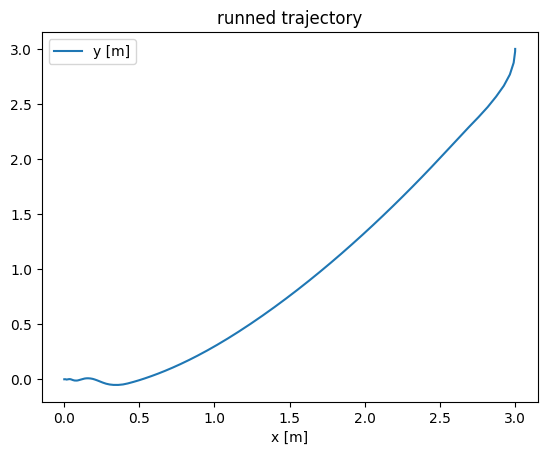

In [ ]:
# df.drop(columns=["t [s]", "stage_obj", "accum_obj"]).plot()

df = df[df["t [s]"] > 0.0005]
df.plot(x="x [m]", y="y [m]", title="runned trajectory")

/tmp/ipykernel_4022/468315634.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["alpha_nominal"] = df.apply(lambda row:-row["alpha [rad]"] + np.arctan2(-row["y [m]"], -row["x [m]"]), axis=1)
/tmp/ipykernel_4022/468315634.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["alpha_nominal"] = df["alpha_nominal"].apply(lambda value: 2*np.pi - value if value > np.pi else value)
/tmp/ipykernel_4022/468315634.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

<Axes: title={'center': 'runned trajectory'}, xlabel='t [s]'>

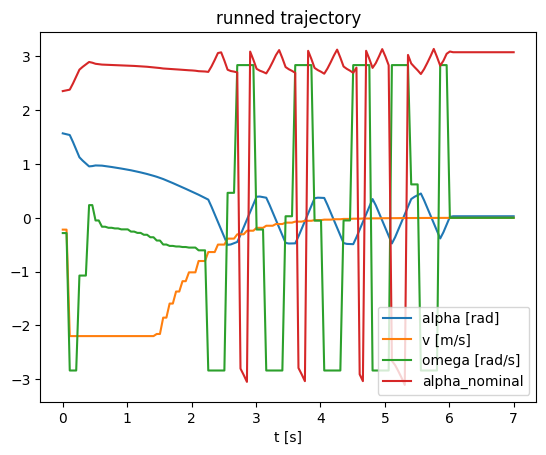

In [ ]:
import numpy as np

df["alpha_nominal"] = df.apply(lambda row:-row["alpha [rad]"] + np.arctan2(-row["y [m]"], -row["x [m]"]), axis=1)
df["alpha_nominal"] = df["alpha_nominal"].apply(lambda value: 2*np.pi - value if value > np.pi else value)
df["alpha_nominal"] = df["alpha_nominal"].apply(lambda value: 2*np.pi + value if value < -np.pi else value)
# df.plot(x="t [s]", y="alpha", title="runned trajectory")
df.plot(x="t [s]", y=["alpha [rad]", "v [m/s]", "omega [rad/s]", "alpha_nominal"], title="runned trajectory")

In [ ]:
k_a = 20
k_b = -0.05

df["beta"] = df.apply(lambda row:-row["alpha [rad]"] - row["alpha_nominal"], axis=1)
df["re-cal-omega"] = df["alpha_nominal"] * k_a + df["beta"] * k_b
print(df.to_markdown())

|     |     t [s] |       x [m] |        y [m] |   alpha [rad] |       run_obj |   accum_obj |     v [m/s] |   omega [rad/s] | parameters                                                                                                                                                                                                                                                                                                                                                                                                                                      | N_kappa    | state_init                         |   alpha_nominal |     beta |   re-cal-omega |
|----:|----------:|------------:|-------------:|--------------:|--------------:|------------:|------------:|----------------:|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

/tmp/ipykernel_4022/3454920361.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["beta"] = df.apply(lambda row:-row["alpha [rad]"] - row["alpha_nominal"], axis=1)
/tmp/ipykernel_4022/3454920361.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["re-cal-omega"] = df["alpha_nominal"] * k_a + df["beta"] * k_b


In [ ]:
df
df.plot(x="t [s]", y=["stage_obj"], title="object")
df.plot(x="t [s]", y=["x [m]", "y [m]"], title="object")

KeyError: "None of [Index(['stage_obj'], dtype='object')] are in the [columns]"

In [ ]:
np.arctan2(-1.995, -1.763), np.arctan2(1.995, 1.763)

In [ ]:
import numpy as np

initial_position = np.array(np.meshgrid([-3, 0, 3], [-3, 0, 3])).T.reshape(-1, 2) 

In [ ]:
initial_position